# Notebook Proyecto Aprendizaje Profundo

| Nombre | N° Alumno |
| :---: | :---: |
| Vicente García Munizaga | 19637225 |
| Alfredo Medina Klapp | 19642865 |
| Daniel Sebastián Gaete | 19202806 |

# Índice
0. [_Setup_ y librerías](#setup)
1. [Procesamiento y análisis de datos](#parte1)

#0. _Setup_ y librerías <a name="setup"></a>

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import math
import plotly.express as px
from collections import Counter
from os import listdir
from PIL import Image
from os.path import join
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, RandomRotation
import torch.optim as optim
from tqdm import tqdm
import copy
import random

In [ ]:
from IPython.display import clear_output

!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

clear_output()

import os, psutil, humanize
import GPUtil as GPU

GPUs = GPU.getGPUs()
if len(GPUs) > 0:
  gpu = GPUs[0]                  # Only one GPU on Colab and isn’t guaranteed

  def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(  \
      psutil.virtual_memory().available ), " I Proc size: " + \
      humanize.naturalsize( process.memory_info().rss))

    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | \
      Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, \
      gpu.memoryUtil*100, gpu.memoryTotal))

  printm()
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device: ", device)

Gen RAM Free: 12.0 GB  I Proc size: 505.6 MB
GPU RAM Free: 15101MB | Used: 0MB | Util   0% |       Total 15360MB
device:  cuda


#1. Procesamiento y análisis de datos <a name="parte1"></a>

In [ ]:
!wget https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip
!wget https://github.com/brendenlake/omniglot/raw/master/python/images_background.zip
!unzip -qq images_background.zip
!unzip -qq images_evaluation.zip

--2023-07-09 01:43:42--  https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/brendenlake/omniglot/master/python/images_evaluation.zip [following]
--2023-07-09 01:43:42--  https://raw.githubusercontent.com/brendenlake/omniglot/master/python/images_evaluation.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6462886 (6.2M) [application/zip]
Saving to: ‘images_evaluation.zip’

images_evaluation.z 100%[===================>]   6.16M  --.-KB/s    in 0.05s   

2023-07-09 01:43:43 (127 MB/s) - ‘images_evaluation.zip’ saved

In [ ]:
TRAIN_IMAGES_DIR_BASE = "images_background"
EVALUATION_IMAGES_DIR_BASE = "images_evaluation"

In [ ]:
## Leemos todas las imágenes de un alfabeto
def get_alphabet_images_path(base_dir, alphabet_dir_name):
    path_to_alphabet_dir = base_dir + "/" + alphabet_dir_name
    characters = os.listdir(path_to_alphabet_dir)
    images_path = []
    for character in characters:
      images_in_dir = os.listdir(path_to_alphabet_dir + "/" + character + "/")
      images_path += [path_to_alphabet_dir + "/" + character + '/' + image_path for image_path in images_in_dir]
    return np.array(images_path)

In [ ]:
## Mostramos las imágenes del input (la cantidad de imágenes
## debe ser un cuadrado perfecto para que quede cuadriculado)
def show_images(images_paths):
  images_per_row = int(math.sqrt(len(images_paths)))
  fig, axs = plt.subplots(images_per_row, images_per_row, figsize=(10, 10))
  for i, image_path in enumerate(images_paths):
      image = plt.imread(image_path)
      row = i // images_per_row
      col = i % images_per_row
      axs[row, col].imshow(image)
      axs[row, col].axis('off')

  plt.tight_layout()
  plt.show()

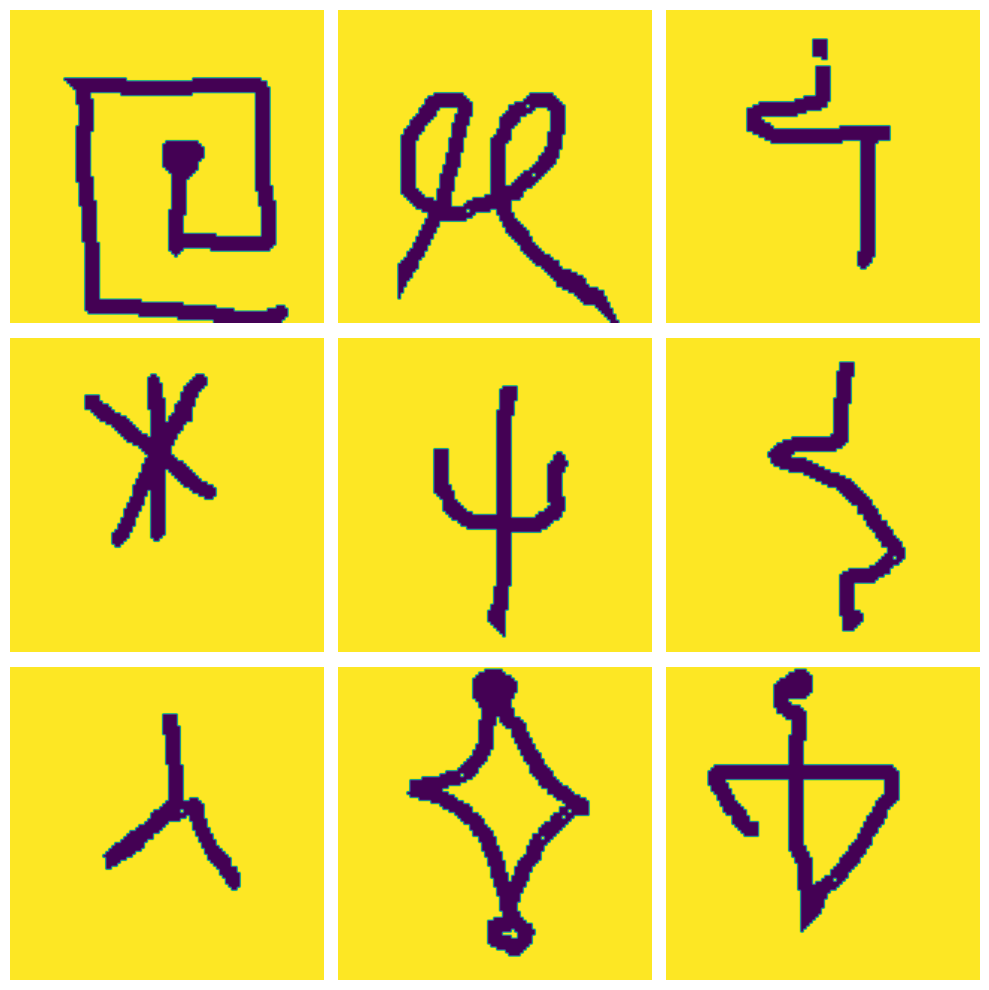

In [ ]:
## Mostramos 9 imágenes random del dataset de entrenamiento
images =  np.random.choice(get_alphabet_images_path(TRAIN_IMAGES_DIR_BASE, "Futurama"), size=9, replace=False)
show_images(images)

In [ ]:
dataset = ImageFolder('/content/images_background')

In [ ]:
dataset_distribution = dict(Counter(dataset.targets))
dataset_distribution_for_plotly = {"Alfabeto (índice)": list(dataset_distribution.keys()), "Número de instancias (imágenes)": list(dataset_distribution.values())}
fig = px.bar(dataset_distribution_for_plotly, x="Alfabeto (índice)", y="Número de instancias (imágenes)")
fig.show()

Los alfabetos no están balanceados porque algunos tienen más caracteres que otros

In [ ]:
class Characters(torch.utils.data.Dataset):
    def __init__(self, root, transform=None, classes_in_train_last=None, start_range=0, range=0, test=False):
        self.root = root
        self.transform = transform
        self.images = []          # Array de arrays de imagenes (por clase)
        self.index_to_class = {}
        self.classes_in_train_last = classes_in_train_last
        self.start_range=start_range
        self.range=range
        self.test = test
        self.images = self.build_indices()

    def build_indices(self):
        class_counter = 0 # Contador para guardar el índice de cada imagen
        image_list = []
        imgs_to_class = []
        for alphabet_directory in listdir(self.root):
          alphabet_dir = join(self.root, alphabet_directory)
          for character_directory in listdir(alphabet_dir):
            current_dir = join(alphabet_dir, character_directory)
            if current_dir not in self.index_to_class:
              self.index_to_class[current_dir] = class_counter
              class_counter+=1
            img_of_class = [join(current_dir, _file) for _file in listdir(current_dir)]
            image_list.append(img_of_class)

        if not self.classes_in_train_last:
          counter = 0
          for _class in image_list:
            counter += len(_class)
          self.classes_in_train_last = counter

        return image_list

    def get_image(self, archivo):
        img = Image.open(archivo)
        return img

    def __getitem__(self, idx):
        img_1 = None
        img_2 = None
        label = None
        if self.test:
          images = self.images[self.start_range:self.start_range+self.range]
        else:
          images = self.images[:self.start_range] + self.images[self.start_range+self.range:self.classes_in_train_last]

        if idx % 2 == 0: # Misma clase
            characters_of_random_class = random.sample(images, 1) # obtenemos las imagenes de alguna clase
            random_imgs_of_class = random.sample(characters_of_random_class[0], 2)
            img_1 = Image.open(random_imgs_of_class[0])
            img_2 = Image.open(random_imgs_of_class[1])
            label = 1.0
        else: # Clases diferentes
            characters_of_random_classes = random.sample(images, 2)
            random_imgs_of_class_1 = random.sample(characters_of_random_classes[0], 1)
            random_imgs_of_class_2 = random.sample(characters_of_random_classes[1], 1)
            img_1 = Image.open(random_imgs_of_class_1[0])
            img_2 = Image.open(random_imgs_of_class_2[0])
            label = 0.0
        if self.transform:

            img_1 = self.transform(img_1.convert('RGB'))
            img_2 = self.transform(img_2.convert('RGB'))
        return img_1, img_2, torch.tensor(label, dtype=torch.float)

    def __len__(self):
        # counter = 0
        # for _class in self.images:
        #   counter += len(_class)
        # return counter
        return 64*30

In [ ]:
from torchvision.models import resnet18

In [ ]:
class SiameseNet(nn.Module):
    def __init__(self, pretrained=False):
        super(SiameseNet, self).__init__()


        self.cnn = resnet18(weights=pretrained)
        self.fc_in_features = self.cnn.fc.in_features

        # eliminamos la ultima capa fc
        self.cnn.fc = nn.Identity()

        self.fc = nn.Sequential(
            nn.Linear(self.fc_in_features * 2, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 1),
        )

        self.sigmoid = nn.Sigmoid()

        self.cnn.apply(self.init_weights)
        self.fc.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

    def forward_once(self, x):
        output = self.cnn(x)
        output = output.view(output.size()[0], -1)
        return output

    def forward(self, input1, input2):
        embeddings1 = self.forward_once(input1)
        embeddings2 = self.forward_once(input2)

        output = torch.cat((embeddings1, embeddings2), 1)

        output = self.fc(output)

        output = self.sigmoid(output)

        return output


In [ ]:
class LearningAnalyzer():
    def __init__(self, root, hparams):
        self.root = root
        self.model_non_pretrained = SiameseNet(pretrained=False).to(device)
        self.model_pretrained = SiameseNet(pretrained=True).to(device)
        self.hparams = hparams
        self.threshold = 0.7
        self.ovrl_history = dict()


    def train(self, model, train_loader, test_loader):
      loss_fn = nn.BCELoss()
      optimizer = optim.Adam(model.parameters(), lr=self.hparams["lr"])
      ovrl_history = {
          'train': {'loss': [], 'acc': []},
          'test': {'loss': [], 'acc': []},
      }
      n_epochs = self.hparams["n_epochs"]
      batch_size = self.hparams["batch_size"]
      for epoch in range(n_epochs):
        model.train()
        losses = []
        cum_loss = 0.0
        cum_acc = 0.0

        with tqdm(train_loader, unit='batch', position=0, leave=True) as tepoch:
          tepoch.set_description(f"Epoch {epoch}/{n_epochs}")
          for batch_idx, (imgs1, imgs2, targets) in enumerate(tepoch, start=1):

            optimizer.zero_grad()
            imgs1 = imgs1.to(device)
            imgs2 = imgs2.to(device)
            targets = targets.to(device)


            outputs = model(imgs1, imgs2).squeeze()
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()

            pred = torch.where(outputs > self.threshold, 1, 0)
            cum_acc += pred.eq(targets.view_as(pred)).sum().item()

            cum_loss += loss.item()
            curr_loss = cum_loss / batch_idx
            curr_acc = cum_acc / (batch_size * batch_idx)

            losses.append(loss.item())

            tepoch.set_postfix(Loss=curr_loss, Acc=curr_acc)

            torch.cuda.empty_cache()

          print()
          print(f"------ Test época {epoch} -------")
          test_acc, test_loss = self.test_model(model, test_loader)
          epoch_loss = float(cum_loss)
          epoch_acc = float(cum_acc / (batch_idx * batch_size))

          # Guardamos el loss y accuracy para la epoca
          ovrl_history['train']['loss'].append(epoch_loss)
          ovrl_history['train']['acc'].append(epoch_acc)
          ovrl_history['test']['loss'].append(test_loss)
          ovrl_history['test']['acc'].append(test_acc)
      return ovrl_history


    def test_model(self, model, test_loader):
      model.eval()
      test_loss = 0
      correct = 0

      criterion = nn.BCELoss()

      with torch.no_grad():
          for (imgs1, imgs2, targets) in test_loader:
              imgs1, imgs2, targets = imgs1.to(device), imgs2.to(device), targets.to(device)
              outputs = model(imgs1, imgs2).squeeze()
              test_loss += criterion(outputs, targets).sum().item()
              pred = torch.where(outputs > self.threshold, 1, 0)
              correct += pred.eq(targets.view_as(pred)).sum().item()

      test_loss /= len(test_loader.dataset)
      test_acc = 100. * correct / len(test_loader.dataset)

      print(f"\nAverage loss: {test_loss}, Accuracy: {correct}/{len(test_loader.dataset)} ({test_acc}%)\n")

      return test_acc, test_loss

    def generate_report(self, train_loader, test_loader):
      ''' Retorna un reporte con los diferentes entrenamientos (diferentes datasets) '''

      self.ovrl_history = self.train(self.model_non_pretrained, train_loader, test_loader)


In [ ]:
from google.colab import drive # importamos la función para montar el drive
import pickle

drive.mount("/content/gdrive", force_remount=True)
# tienes que crear carpeta "proyecto_ap" dentro de "Colab Notebooks" antes de ejecutar este código.
drive_path = 'gdrive/MyDrive/Colab Notebooks/proyecto_ap'

def save_logs(logs, name):
    with open(f"{drive_path}/{name}.pickle", 'wb') as file:
        pickle.dump(logs, file)

def load_logs(name):
    path = f"{drive_path}/{name}.pickle"
    if os.path.exists(path):
        with open(path, 'rb') as file:
            return pickle.load(file)
    return []


Mounted at /content/gdrive


In [ ]:
hparams = {"lr": 0.0005 , "batch_size": 32, "n_epochs": 20, "input_size": 224}
# analyzer = LearningAnalyzer(TRAIN_IMAGES_DIR_BASE, hparams)

In [ ]:
# _transform = Compose([Resize((hparams["input_size"], hparams["input_size"])),
#                     ToTensor(), Normalize((.5, .5, .5), (.5, .5, .5))])
# _train = Characters(TRAIN_IMAGES_DIR_BASE, transform=_transform, start_range=20, range=40)
# _test = Characters(EVALUATION_IMAGES_DIR_BASE, transform=_transform)
# train_loader = DataLoader(_train, batch_size=hparams['batch_size'], shuffle=True)
# test_loader = DataLoader(_test, batch_size=hparams['batch_size'], shuffle=True)

In [ ]:
last = 320
print(last)
analyzer = LearningAnalyzer(TRAIN_IMAGES_DIR_BASE, hparams)
_transform = Compose([Resize((hparams["input_size"], hparams["input_size"])),
                      ToTensor(), Normalize((.5, .5, .5), (.5, .5, .5))])
_train = Characters(TRAIN_IMAGES_DIR_BASE, transform=_transform, classes_in_train_last=last)
_test = Characters(EVALUATION_IMAGES_DIR_BASE, transform=_transform)
train_loader = DataLoader(_train, batch_size=hparams['batch_size'], shuffle=True)
test_loader = DataLoader(_test, batch_size=hparams['batch_size'], shuffle=True)

analyzer.generate_report(train_loader, test_loader)
save_logs(analyzer.ovrl_history,f"incremental_not_pretrained_{last}")

320


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 78.8MB/s]
Epoch 0/20: 100%|██████████| 60/60 [00:26<00:00,  2.29batch/s, Acc=0.574, Loss=0.664]



------ Test época 0 -------

Average loss: 0.020441949755574267, Accuracy: 1225/1920 (63.802083333333336%)



Epoch 1/20: 100%|██████████| 60/60 [00:20<00:00,  2.99batch/s, Acc=0.619, Loss=0.584]



------ Test época 1 -------

Average loss: 0.016964805234844487, Accuracy: 1145/1920 (59.635416666666664%)



Epoch 2/20: 100%|██████████| 60/60 [00:20<00:00,  2.97batch/s, Acc=0.655, Loss=0.529]



------ Test época 2 -------

Average loss: 0.015780071960762143, Accuracy: 1293/1920 (67.34375%)



Epoch 3/20: 100%|██████████| 60/60 [00:19<00:00,  3.02batch/s, Acc=0.625, Loss=0.527]



------ Test época 3 -------

Average loss: 0.019610277159760395, Accuracy: 1220/1920 (63.541666666666664%)



Epoch 4/20: 100%|██████████| 60/60 [00:19<00:00,  3.05batch/s, Acc=0.662, Loss=0.515]



------ Test época 4 -------

Average loss: 0.01808519260957837, Accuracy: 1043/1920 (54.322916666666664%)



Epoch 5/20: 100%|██████████| 60/60 [00:20<00:00,  3.00batch/s, Acc=0.66, Loss=0.509]



------ Test época 5 -------

Average loss: 0.01771067287772894, Accuracy: 1091/1920 (56.822916666666664%)



Epoch 6/20: 100%|██████████| 60/60 [00:20<00:00,  2.97batch/s, Acc=0.692, Loss=0.484]



------ Test época 6 -------

Average loss: 0.017526485227669277, Accuracy: 1223/1920 (63.697916666666664%)



Epoch 7/20: 100%|██████████| 60/60 [00:20<00:00,  2.96batch/s, Acc=0.686, Loss=0.503]



------ Test época 7 -------

Average loss: 0.01741915928820769, Accuracy: 1217/1920 (63.385416666666664%)



Epoch 8/20: 100%|██████████| 60/60 [00:19<00:00,  3.04batch/s, Acc=0.672, Loss=0.502]



------ Test época 8 -------

Average loss: 0.01728998967446387, Accuracy: 1175/1920 (61.197916666666664%)



Epoch 9/20: 100%|██████████| 60/60 [00:20<00:00,  2.96batch/s, Acc=0.667, Loss=0.519]



------ Test época 9 -------

Average loss: 0.016858475236222147, Accuracy: 1248/1920 (65.0%)



Epoch 10/20: 100%|██████████| 60/60 [00:19<00:00,  3.02batch/s, Acc=0.667, Loss=0.497]



------ Test época 10 -------

Average loss: 0.01613452808621029, Accuracy: 1304/1920 (67.91666666666667%)



Epoch 11/20: 100%|██████████| 60/60 [00:20<00:00,  2.94batch/s, Acc=0.701, Loss=0.481]



------ Test época 11 -------

Average loss: 0.018000326150407395, Accuracy: 1320/1920 (68.75%)



Epoch 12/20: 100%|██████████| 60/60 [00:20<00:00,  3.00batch/s, Acc=0.71, Loss=0.475]



------ Test época 12 -------

Average loss: 0.01618268936872482, Accuracy: 1425/1920 (74.21875%)



Epoch 13/20: 100%|██████████| 60/60 [00:21<00:00,  2.84batch/s, Acc=0.691, Loss=0.494]



------ Test época 13 -------

Average loss: 0.01713575089039902, Accuracy: 1178/1920 (61.354166666666664%)



Epoch 14/20: 100%|██████████| 60/60 [00:20<00:00,  2.90batch/s, Acc=0.688, Loss=0.485]



------ Test época 14 -------

Average loss: 0.016800020743782323, Accuracy: 1370/1920 (71.35416666666667%)



Epoch 15/20: 100%|██████████| 60/60 [00:19<00:00,  3.02batch/s, Acc=0.714, Loss=0.47]



------ Test época 15 -------

Average loss: 0.016688167753939828, Accuracy: 1330/1920 (69.27083333333333%)



Epoch 16/20: 100%|██████████| 60/60 [00:20<00:00,  2.94batch/s, Acc=0.723, Loss=0.46]



------ Test época 16 -------

Average loss: 0.016043863290299974, Accuracy: 1336/1920 (69.58333333333333%)



Epoch 17/20: 100%|██████████| 60/60 [00:20<00:00,  2.88batch/s, Acc=0.726, Loss=0.464]



------ Test época 17 -------

Average loss: 0.016268317804982266, Accuracy: 1418/1920 (73.85416666666667%)



Epoch 18/20: 100%|██████████| 60/60 [00:20<00:00,  2.95batch/s, Acc=0.715, Loss=0.465]



------ Test época 18 -------

Average loss: 0.01647005562360088, Accuracy: 1428/1920 (74.375%)



Epoch 19/20: 100%|██████████| 60/60 [00:20<00:00,  3.00batch/s, Acc=0.751, Loss=0.456]



------ Test época 19 -------


In [ ]:
init = 20
for i in range(0, 6):
    last = 2**(i)*init
    print(last)
    analyzer = LearningAnalyzer(TRAIN_IMAGES_DIR_BASE, hparams)
    _transform = Compose([Resize((hparams["input_size"], hparams["input_size"])),
                        ToTensor(), Normalize((.5, .5, .5), (.5, .5, .5))])
    _train = Characters(TRAIN_IMAGES_DIR_BASE, transform=_transform, classes_in_train_last=last)
    _test = Characters(EVALUATION_IMAGES_DIR_BASE, transform=_transform)
    train_loader = DataLoader(_train, batch_size=hparams['batch_size'], shuffle=True)
    test_loader = DataLoader(_test, batch_size=hparams['batch_size'], shuffle=True)

    analyzer.generate_report(train_loader, test_loader)
    save_logs(analyzer.ovrl_history,f"incremental_not_pretrained_{last}")

20


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 178MB/s]
Epoch 0/20: 100%|██████████| 60/60 [00:26<00:00,  2.23batch/s, Acc=0.589, Loss=0.645]



------ Test época 0 -------

Average loss: 0.03203695646176736, Accuracy: 1267/1920 (65.98958333333333%)



Epoch 1/20: 100%|██████████| 60/60 [00:19<00:00,  3.04batch/s, Acc=0.708, Loss=0.478]



------ Test época 1 -------

Average loss: 0.020259394962340593, Accuracy: 1292/1920 (67.29166666666667%)



Epoch 2/20: 100%|██████████| 60/60 [00:21<00:00,  2.74batch/s, Acc=0.739, Loss=0.423]



------ Test época 2 -------

Average loss: 0.016955147435267767, Accuracy: 1217/1920 (63.385416666666664%)



Epoch 3/20: 100%|██████████| 60/60 [00:20<00:00,  2.99batch/s, Acc=0.76, Loss=0.42]



------ Test época 3 -------

Average loss: 0.02093629988376051, Accuracy: 1295/1920 (67.44791666666667%)



Epoch 4/20: 100%|██████████| 60/60 [00:19<00:00,  3.05batch/s, Acc=0.773, Loss=0.386]



------ Test época 4 -------

Average loss: 0.02175353616476059, Accuracy: 1356/1920 (70.625%)



Epoch 5/20: 100%|██████████| 60/60 [00:19<00:00,  3.05batch/s, Acc=0.759, Loss=0.396]



------ Test época 5 -------

Average loss: 0.01707349099839727, Accuracy: 1261/1920 (65.67708333333333%)



Epoch 6/20: 100%|██████████| 60/60 [00:20<00:00,  3.00batch/s, Acc=0.769, Loss=0.396]



------ Test época 6 -------

Average loss: 0.017705684217313927, Accuracy: 1180/1920 (61.458333333333336%)



Epoch 7/20: 100%|██████████| 60/60 [00:20<00:00,  2.97batch/s, Acc=0.816, Loss=0.36]



------ Test época 7 -------

Average loss: 0.023558642559995253, Accuracy: 1399/1920 (72.86458333333333%)



Epoch 8/20: 100%|██████████| 60/60 [00:20<00:00,  3.00batch/s, Acc=0.834, Loss=0.341]



------ Test época 8 -------

Average loss: 0.01914871556994816, Accuracy: 1248/1920 (65.0%)



Epoch 9/20: 100%|██████████| 60/60 [00:19<00:00,  3.04batch/s, Acc=0.82, Loss=0.335]



------ Test época 9 -------

Average loss: 0.019491170664938787, Accuracy: 1391/1920 (72.44791666666667%)



Epoch 10/20: 100%|██████████| 60/60 [00:19<00:00,  3.04batch/s, Acc=0.83, Loss=0.337]



------ Test época 10 -------

Average loss: 0.016145596210844815, Accuracy: 1423/1920 (74.11458333333333%)



Epoch 11/20: 100%|██████████| 60/60 [00:19<00:00,  3.05batch/s, Acc=0.853, Loss=0.283]



------ Test época 11 -------

Average loss: 0.02053067646920681, Accuracy: 1404/1920 (73.125%)



Epoch 12/20: 100%|██████████| 60/60 [00:20<00:00,  3.00batch/s, Acc=0.879, Loss=0.26]



------ Test época 12 -------

Average loss: 0.025833323271945118, Accuracy: 1409/1920 (73.38541666666667%)



Epoch 13/20: 100%|██████████| 60/60 [00:20<00:00,  2.97batch/s, Acc=0.907, Loss=0.23]



------ Test época 13 -------

Average loss: 0.017946541930238407, Accuracy: 1507/1920 (78.48958333333333%)



Epoch 14/20: 100%|██████████| 60/60 [00:19<00:00,  3.02batch/s, Acc=0.882, Loss=0.245]



------ Test época 14 -------

Average loss: 0.01612880138369898, Accuracy: 1509/1920 (78.59375%)



Epoch 15/20: 100%|██████████| 60/60 [00:19<00:00,  3.06batch/s, Acc=0.917, Loss=0.194]



------ Test época 15 -------

Average loss: 0.017584684041018286, Accuracy: 1446/1920 (75.3125%)



Epoch 16/20: 100%|██████████| 60/60 [00:19<00:00,  3.06batch/s, Acc=0.923, Loss=0.175]



------ Test época 16 -------

Average loss: 0.01973994355648756, Accuracy: 1468/1920 (76.45833333333333%)



Epoch 17/20: 100%|██████████| 60/60 [00:20<00:00,  2.96batch/s, Acc=0.92, Loss=0.187]



------ Test época 17 -------

Average loss: 0.0207570837965856, Accuracy: 1434/1920 (74.6875%)



Epoch 18/20: 100%|██████████| 60/60 [00:20<00:00,  2.97batch/s, Acc=0.921, Loss=0.182]



------ Test época 18 -------

Average loss: 0.019037769509789845, Accuracy: 1454/1920 (75.72916666666667%)



Epoch 19/20: 100%|██████████| 60/60 [00:20<00:00,  2.98batch/s, Acc=0.945, Loss=0.14]



------ Test época 19 -------

Average loss: 0.020475208402300875, Accuracy: 1414/1920 (73.64583333333333%)

40


Epoch 0/20: 100%|██████████| 60/60 [00:19<00:00,  3.05batch/s, Acc=0.562, Loss=0.643]



------ Test época 0 -------

Average loss: 0.030217645224183798, Accuracy: 1336/1920 (69.58333333333333%)



Epoch 1/20: 100%|██████████| 60/60 [00:19<00:00,  3.02batch/s, Acc=0.649, Loss=0.516]



------ Test época 1 -------

Average loss: 0.017805548881491027, Accuracy: 1309/1920 (68.17708333333333%)



Epoch 2/20: 100%|██████████| 60/60 [00:20<00:00,  3.00batch/s, Acc=0.694, Loss=0.489]



------ Test época 2 -------

Average loss: 0.022926525337000687, Accuracy: 1309/1920 (68.17708333333333%)



Epoch 3/20: 100%|██████████| 60/60 [00:19<00:00,  3.00batch/s, Acc=0.69, Loss=0.479]



------ Test época 3 -------

Average loss: 0.01843273884927233, Accuracy: 1189/1920 (61.927083333333336%)



Epoch 4/20: 100%|██████████| 60/60 [00:19<00:00,  3.07batch/s, Acc=0.736, Loss=0.43]



------ Test época 4 -------

Average loss: 0.018987601762637495, Accuracy: 1299/1920 (67.65625%)



Epoch 5/20: 100%|██████████| 60/60 [00:19<00:00,  3.06batch/s, Acc=0.746, Loss=0.443]



------ Test época 5 -------

Average loss: 0.016372511497077843, Accuracy: 1281/1920 (66.71875%)



Epoch 6/20: 100%|██████████| 60/60 [00:20<00:00,  2.98batch/s, Acc=0.708, Loss=0.458]



------ Test época 6 -------

Average loss: 0.01638142188700537, Accuracy: 1319/1920 (68.69791666666667%)



Epoch 7/20: 100%|██████████| 60/60 [00:20<00:00,  2.99batch/s, Acc=0.751, Loss=0.431]



------ Test época 7 -------

Average loss: 0.01966758893492321, Accuracy: 1118/1920 (58.229166666666664%)



Epoch 8/20: 100%|██████████| 60/60 [00:19<00:00,  3.04batch/s, Acc=0.737, Loss=0.428]



------ Test época 8 -------

Average loss: 0.018477924959734084, Accuracy: 1374/1920 (71.5625%)



Epoch 9/20: 100%|██████████| 60/60 [00:19<00:00,  3.02batch/s, Acc=0.742, Loss=0.424]



------ Test época 9 -------

Average loss: 0.016995383612811565, Accuracy: 1338/1920 (69.6875%)



Epoch 10/20: 100%|██████████| 60/60 [00:20<00:00,  2.94batch/s, Acc=0.772, Loss=0.409]



------ Test época 10 -------

Average loss: 0.01715042640765508, Accuracy: 1451/1920 (75.57291666666667%)



Epoch 11/20: 100%|██████████| 60/60 [00:20<00:00,  2.98batch/s, Acc=0.792, Loss=0.399]



------ Test época 11 -------

Average loss: 0.021445786595965424, Accuracy: 1395/1920 (72.65625%)



Epoch 12/20: 100%|██████████| 60/60 [00:19<00:00,  3.01batch/s, Acc=0.783, Loss=0.412]



------ Test época 12 -------

Average loss: 0.02167816643292705, Accuracy: 1420/1920 (73.95833333333333%)



Epoch 13/20: 100%|██████████| 60/60 [00:19<00:00,  3.07batch/s, Acc=0.787, Loss=0.394]



------ Test época 13 -------

Average loss: 0.017475188011303544, Accuracy: 1401/1920 (72.96875%)



Epoch 14/20: 100%|██████████| 60/60 [00:20<00:00,  2.99batch/s, Acc=0.777, Loss=0.396]



------ Test época 14 -------

Average loss: 0.022325381791839998, Accuracy: 1425/1920 (74.21875%)



Epoch 15/20: 100%|██████████| 60/60 [00:19<00:00,  3.01batch/s, Acc=0.812, Loss=0.368]



------ Test época 15 -------

Average loss: 0.017408498205865423, Accuracy: 1415/1920 (73.69791666666667%)



Epoch 16/20: 100%|██████████| 60/60 [00:20<00:00,  3.00batch/s, Acc=0.793, Loss=0.388]



------ Test época 16 -------

Average loss: 0.017952753906138243, Accuracy: 1429/1920 (74.42708333333333%)



Epoch 17/20: 100%|██████████| 60/60 [00:19<00:00,  3.01batch/s, Acc=0.836, Loss=0.337]



------ Test época 17 -------

Average loss: 0.022031775016027193, Accuracy: 1369/1920 (71.30208333333333%)



Epoch 18/20: 100%|██████████| 60/60 [00:20<00:00,  2.99batch/s, Acc=0.808, Loss=0.378]



------ Test época 18 -------

Average loss: 0.01841371290696164, Accuracy: 1411/1920 (73.48958333333333%)



Epoch 19/20: 100%|██████████| 60/60 [00:19<00:00,  3.05batch/s, Acc=0.83, Loss=0.344]



------ Test época 19 -------

Average loss: 0.019274701581647, Accuracy: 1381/1920 (71.92708333333333%)

80


Epoch 0/20: 100%|██████████| 60/60 [00:20<00:00,  2.96batch/s, Acc=0.555, Loss=0.732]



------ Test época 0 -------

Average loss: 0.019151543080806733, Accuracy: 1141/1920 (59.427083333333336%)



Epoch 1/20: 100%|██████████| 60/60 [00:20<00:00,  2.94batch/s, Acc=0.603, Loss=0.591]



------ Test época 1 -------

Average loss: 0.020692246810843546, Accuracy: 1125/1920 (58.59375%)



Epoch 2/20: 100%|██████████| 60/60 [00:20<00:00,  2.92batch/s, Acc=0.615, Loss=0.546]



------ Test época 2 -------

Average loss: 0.018489631754346193, Accuracy: 1288/1920 (67.08333333333333%)



Epoch 3/20: 100%|██████████| 60/60 [00:19<00:00,  3.02batch/s, Acc=0.647, Loss=0.536]



------ Test época 3 -------

Average loss: 0.019956633060549695, Accuracy: 1294/1920 (67.39583333333333%)



Epoch 4/20: 100%|██████████| 60/60 [00:19<00:00,  3.04batch/s, Acc=0.682, Loss=0.505]



------ Test época 4 -------

Average loss: 0.01605966469893853, Accuracy: 1173/1920 (61.09375%)



Epoch 5/20: 100%|██████████| 60/60 [00:20<00:00,  2.97batch/s, Acc=0.666, Loss=0.503]



------ Test época 5 -------

Average loss: 0.016255505864198008, Accuracy: 1322/1920 (68.85416666666667%)



Epoch 6/20: 100%|██████████| 60/60 [00:20<00:00,  2.91batch/s, Acc=0.751, Loss=0.437]



------ Test época 6 -------

Average loss: 0.01654788120649755, Accuracy: 1309/1920 (68.17708333333333%)



Epoch 7/20: 100%|██████████| 60/60 [00:19<00:00,  3.03batch/s, Acc=0.686, Loss=0.482]



------ Test época 7 -------

Average loss: 0.017508174991235137, Accuracy: 1239/1920 (64.53125%)



Epoch 8/20: 100%|██████████| 60/60 [00:19<00:00,  3.06batch/s, Acc=0.713, Loss=0.461]



------ Test época 8 -------

Average loss: 0.015776164705554645, Accuracy: 1379/1920 (71.82291666666667%)



Epoch 9/20: 100%|██████████| 60/60 [00:19<00:00,  3.03batch/s, Acc=0.735, Loss=0.445]



------ Test época 9 -------

Average loss: 0.015060611488297581, Accuracy: 1434/1920 (74.6875%)



Epoch 10/20: 100%|██████████| 60/60 [00:20<00:00,  2.87batch/s, Acc=0.741, Loss=0.42]



------ Test época 10 -------

Average loss: 0.01481835013255477, Accuracy: 1395/1920 (72.65625%)



Epoch 11/20: 100%|██████████| 60/60 [00:20<00:00,  2.98batch/s, Acc=0.792, Loss=0.39]



------ Test época 11 -------

Average loss: 0.015452741738408804, Accuracy: 1362/1920 (70.9375%)



Epoch 12/20: 100%|██████████| 60/60 [00:19<00:00,  3.01batch/s, Acc=0.799, Loss=0.37]



------ Test época 12 -------

Average loss: 0.014898814121261239, Accuracy: 1497/1920 (77.96875%)



Epoch 13/20: 100%|██████████| 60/60 [00:20<00:00,  2.96batch/s, Acc=0.793, Loss=0.365]



------ Test época 13 -------

Average loss: 0.014696666629364093, Accuracy: 1426/1920 (74.27083333333333%)



Epoch 14/20: 100%|██████████| 60/60 [00:20<00:00,  2.93batch/s, Acc=0.825, Loss=0.328]



------ Test época 14 -------

Average loss: 0.01598305211712917, Accuracy: 1487/1920 (77.44791666666667%)



Epoch 15/20: 100%|██████████| 60/60 [00:20<00:00,  2.99batch/s, Acc=0.827, Loss=0.359]



------ Test época 15 -------

Average loss: 0.016960206038008133, Accuracy: 1437/1920 (74.84375%)



Epoch 16/20: 100%|██████████| 60/60 [00:20<00:00,  2.99batch/s, Acc=0.843, Loss=0.313]



------ Test época 16 -------

Average loss: 0.014550186367705465, Accuracy: 1476/1920 (76.875%)



Epoch 17/20: 100%|██████████| 60/60 [00:19<00:00,  3.02batch/s, Acc=0.838, Loss=0.318]



------ Test época 17 -------

Average loss: 0.014001141247960428, Accuracy: 1452/1920 (75.625%)



Epoch 18/20: 100%|██████████| 60/60 [00:20<00:00,  2.99batch/s, Acc=0.833, Loss=0.328]



------ Test época 18 -------

Average loss: 0.014769029702680807, Accuracy: 1459/1920 (75.98958333333333%)



Epoch 19/20: 100%|██████████| 60/60 [00:19<00:00,  3.04batch/s, Acc=0.832, Loss=0.33]



------ Test época 19 -------

Average loss: 0.013685485503325859, Accuracy: 1470/1920 (76.5625%)

160


Epoch 0/20: 100%|██████████| 60/60 [00:20<00:00,  2.95batch/s, Acc=0.547, Loss=0.704]



------ Test época 0 -------

Average loss: 0.026101048414905865, Accuracy: 1313/1920 (68.38541666666667%)



Epoch 1/20: 100%|██████████| 60/60 [00:20<00:00,  2.99batch/s, Acc=0.606, Loss=0.609]



------ Test época 1 -------

Average loss: 0.06223710458725691, Accuracy: 1165/1920 (60.677083333333336%)



Epoch 2/20: 100%|██████████| 60/60 [00:20<00:00,  2.99batch/s, Acc=0.614, Loss=0.586]



------ Test época 2 -------

Average loss: 0.016739925276488064, Accuracy: 1370/1920 (71.35416666666667%)



Epoch 3/20: 100%|██████████| 60/60 [00:19<00:00,  3.09batch/s, Acc=0.656, Loss=0.51]



------ Test época 3 -------

Average loss: 0.017225485822806755, Accuracy: 1109/1920 (57.760416666666664%)



Epoch 4/20: 100%|██████████| 60/60 [00:19<00:00,  3.03batch/s, Acc=0.65, Loss=0.518]



------ Test época 4 -------

Average loss: 0.016520203603431583, Accuracy: 1245/1920 (64.84375%)



Epoch 5/20: 100%|██████████| 60/60 [00:19<00:00,  3.01batch/s, Acc=0.683, Loss=0.504]



------ Test época 5 -------

Average loss: 0.023278751922771335, Accuracy: 1357/1920 (70.67708333333333%)



Epoch 6/20: 100%|██████████| 60/60 [00:20<00:00,  2.95batch/s, Acc=0.671, Loss=0.5]



------ Test época 6 -------

Average loss: 0.015659445182730755, Accuracy: 1361/1920 (70.88541666666667%)



Epoch 7/20: 100%|██████████| 60/60 [00:19<00:00,  3.03batch/s, Acc=0.718, Loss=0.487]



------ Test época 7 -------

Average loss: 0.016027462187533578, Accuracy: 1212/1920 (63.125%)



Epoch 8/20: 100%|██████████| 60/60 [00:19<00:00,  3.09batch/s, Acc=0.741, Loss=0.476]



------ Test época 8 -------

Average loss: 0.013949267566204071, Accuracy: 1459/1920 (75.98958333333333%)



Epoch 9/20: 100%|██████████| 60/60 [00:19<00:00,  3.09batch/s, Acc=0.733, Loss=0.455]



------ Test época 9 -------

Average loss: 0.0169474626891315, Accuracy: 1232/1920 (64.16666666666667%)



Epoch 10/20: 100%|██████████| 60/60 [00:20<00:00,  2.97batch/s, Acc=0.77, Loss=0.421]



------ Test época 10 -------

Average loss: 0.014444901344055931, Accuracy: 1492/1920 (77.70833333333333%)



Epoch 11/20: 100%|██████████| 60/60 [00:19<00:00,  3.03batch/s, Acc=0.767, Loss=0.42]



------ Test época 11 -------

Average loss: 0.015601850906386971, Accuracy: 1481/1920 (77.13541666666667%)



Epoch 12/20: 100%|██████████| 60/60 [00:20<00:00,  3.00batch/s, Acc=0.798, Loss=0.385]



------ Test época 12 -------

Average loss: 0.016541182086803018, Accuracy: 1426/1920 (74.27083333333333%)



Epoch 13/20: 100%|██████████| 60/60 [00:20<00:00,  3.00batch/s, Acc=0.782, Loss=0.405]



------ Test época 13 -------

Average loss: 0.015020990821843347, Accuracy: 1487/1920 (77.44791666666667%)



Epoch 14/20: 100%|██████████| 60/60 [00:20<00:00,  2.96batch/s, Acc=0.792, Loss=0.39]



------ Test época 14 -------

Average loss: 0.014836612343788146, Accuracy: 1487/1920 (77.44791666666667%)



Epoch 15/20: 100%|██████████| 60/60 [00:19<00:00,  3.07batch/s, Acc=0.795, Loss=0.392]



------ Test época 15 -------

Average loss: 0.012330399546772241, Accuracy: 1511/1920 (78.69791666666667%)



Epoch 16/20: 100%|██████████| 60/60 [00:19<00:00,  3.03batch/s, Acc=0.836, Loss=0.334]



------ Test época 16 -------

Average loss: 0.014318972360342741, Accuracy: 1532/1920 (79.79166666666667%)



Epoch 17/20: 100%|██████████| 60/60 [00:19<00:00,  3.01batch/s, Acc=0.802, Loss=0.389]



------ Test época 17 -------

Average loss: 0.01395252999694397, Accuracy: 1446/1920 (75.3125%)



Epoch 18/20: 100%|██████████| 60/60 [00:20<00:00,  2.94batch/s, Acc=0.81, Loss=0.371]



------ Test época 18 -------

Average loss: 0.016733892696599164, Accuracy: 1479/1920 (77.03125%)



Epoch 19/20: 100%|██████████| 60/60 [00:19<00:00,  3.06batch/s, Acc=0.803, Loss=0.371]



------ Test época 19 -------

Average loss: 0.014629928146799405, Accuracy: 1517/1920 (79.01041666666667%)

320


Epoch 0/20: 100%|██████████| 60/60 [00:19<00:00,  3.06batch/s, Acc=0.569, Loss=0.715]



------ Test época 0 -------

Average loss: 0.025246944418177007, Accuracy: 1238/1920 (64.47916666666667%)



Epoch 1/20: 100%|██████████| 60/60 [00:19<00:00,  3.03batch/s, Acc=0.619, Loss=0.578]



------ Test época 1 -------

Average loss: 0.016950630924353997, Accuracy: 1189/1920 (61.927083333333336%)



Epoch 2/20: 100%|██████████| 60/60 [00:20<00:00,  2.94batch/s, Acc=0.66, Loss=0.524]



------ Test época 2 -------

Average loss: 0.019429471949115394, Accuracy: 1353/1920 (70.46875%)



Epoch 3/20: 100%|██████████| 60/60 [00:20<00:00,  2.95batch/s, Acc=0.624, Loss=0.55]



------ Test época 3 -------

Average loss: 0.018888944014906883, Accuracy: 1222/1920 (63.645833333333336%)



Epoch 4/20: 100%|██████████| 60/60 [00:19<00:00,  3.07batch/s, Acc=0.671, Loss=0.506]



------ Test época 4 -------

Average loss: 0.016909683387105665, Accuracy: 1382/1920 (71.97916666666667%)



Epoch 5/20: 100%|██████████| 60/60 [00:19<00:00,  3.03batch/s, Acc=0.634, Loss=0.533]



------ Test época 5 -------

Average loss: 0.019027443105975785, Accuracy: 1362/1920 (70.9375%)



Epoch 6/20: 100%|██████████| 60/60 [00:20<00:00,  2.97batch/s, Acc=0.661, Loss=0.523]



------ Test época 6 -------

Average loss: 0.019493912036220234, Accuracy: 1046/1920 (54.479166666666664%)



Epoch 7/20: 100%|██████████| 60/60 [00:19<00:00,  3.00batch/s, Acc=0.651, Loss=0.535]



------ Test época 7 -------

Average loss: 0.016799630286792915, Accuracy: 1262/1920 (65.72916666666667%)



Epoch 8/20: 100%|██████████| 60/60 [00:19<00:00,  3.05batch/s, Acc=0.653, Loss=0.512]



------ Test época 8 -------

Average loss: 0.01777339881906907, Accuracy: 1339/1920 (69.73958333333333%)



Epoch 9/20: 100%|██████████| 60/60 [00:19<00:00,  3.06batch/s, Acc=0.643, Loss=0.55]



------ Test época 9 -------

Average loss: 0.018851613020524384, Accuracy: 1310/1920 (68.22916666666667%)



Epoch 10/20: 100%|██████████| 60/60 [00:19<00:00,  3.06batch/s, Acc=0.666, Loss=0.499]



------ Test época 10 -------

Average loss: 0.018213448176781336, Accuracy: 1357/1920 (70.67708333333333%)



Epoch 11/20: 100%|██████████| 60/60 [00:19<00:00,  3.03batch/s, Acc=0.688, Loss=0.483]



------ Test época 11 -------

Average loss: 0.015961380489170552, Accuracy: 1250/1920 (65.10416666666667%)



Epoch 12/20: 100%|██████████| 60/60 [00:19<00:00,  3.01batch/s, Acc=0.665, Loss=0.514]



------ Test época 12 -------

Average loss: 0.016863564619173606, Accuracy: 1151/1920 (59.947916666666664%)



Epoch 13/20: 100%|██████████| 60/60 [00:19<00:00,  3.04batch/s, Acc=0.664, Loss=0.497]



------ Test época 13 -------

Average loss: 0.01886672622834643, Accuracy: 1314/1920 (68.4375%)



Epoch 14/20: 100%|██████████| 60/60 [00:19<00:00,  3.11batch/s, Acc=0.664, Loss=0.523]



------ Test época 14 -------

Average loss: 0.01595031681160132, Accuracy: 1183/1920 (61.614583333333336%)



Epoch 15/20: 100%|██████████| 60/60 [00:19<00:00,  3.06batch/s, Acc=0.666, Loss=0.504]



------ Test época 15 -------

Average loss: 0.019394493382424115, Accuracy: 1392/1920 (72.5%)



Epoch 16/20: 100%|██████████| 60/60 [00:19<00:00,  3.05batch/s, Acc=0.691, Loss=0.483]



------ Test época 16 -------

Average loss: 0.015617653463656704, Accuracy: 1326/1920 (69.0625%)



Epoch 17/20: 100%|██████████| 60/60 [00:19<00:00,  3.00batch/s, Acc=0.711, Loss=0.482]



------ Test época 17 -------

Average loss: 0.0156896888744086, Accuracy: 1326/1920 (69.0625%)



Epoch 18/20: 100%|██████████| 60/60 [00:19<00:00,  3.05batch/s, Acc=0.699, Loss=0.489]



------ Test época 18 -------

Average loss: 0.015849548391997814, Accuracy: 1422/1920 (74.0625%)



Epoch 19/20: 100%|██████████| 60/60 [00:19<00:00,  3.09batch/s, Acc=0.679, Loss=0.496]



------ Test época 19 -------

Average loss: 0.018280372954905033, Accuracy: 1400/1920 (72.91666666666667%)

640


Epoch 0/20: 100%|██████████| 60/60 [00:19<00:00,  3.04batch/s, Acc=0.558, Loss=0.702]



------ Test época 0 -------

Average loss: 0.019586920055250326, Accuracy: 1071/1920 (55.78125%)



Epoch 1/20: 100%|██████████| 60/60 [00:20<00:00,  3.00batch/s, Acc=0.569, Loss=0.637]



------ Test época 1 -------

Average loss: 0.02049082997255027, Accuracy: 1154/1920 (60.104166666666664%)



Epoch 2/20: 100%|██████████| 60/60 [00:19<00:00,  3.03batch/s, Acc=0.572, Loss=0.603]



------ Test época 2 -------

Average loss: 0.01845334198636313, Accuracy: 1035/1920 (53.90625%)



Epoch 3/20: 100%|██████████| 60/60 [00:20<00:00,  2.99batch/s, Acc=0.614, Loss=0.56]



------ Test época 3 -------

Average loss: 0.017527601992090542, Accuracy: 1123/1920 (58.489583333333336%)



Epoch 4/20: 100%|██████████| 60/60 [00:19<00:00,  3.06batch/s, Acc=0.652, Loss=0.519]



------ Test época 4 -------

Average loss: 0.016417133202776314, Accuracy: 1204/1920 (62.708333333333336%)



Epoch 5/20: 100%|██████████| 60/60 [00:19<00:00,  3.01batch/s, Acc=0.665, Loss=0.522]



------ Test época 5 -------

Average loss: 0.01730610216036439, Accuracy: 1097/1920 (57.135416666666664%)



Epoch 6/20: 100%|██████████| 60/60 [00:19<00:00,  3.07batch/s, Acc=0.63, Loss=0.535]



------ Test época 6 -------

Average loss: 0.017222427980353436, Accuracy: 1203/1920 (62.65625%)



Epoch 7/20: 100%|██████████| 60/60 [00:19<00:00,  3.02batch/s, Acc=0.672, Loss=0.491]



------ Test época 7 -------

Average loss: 0.01653652690971891, Accuracy: 1183/1920 (61.614583333333336%)



Epoch 8/20: 100%|██████████| 60/60 [00:19<00:00,  3.03batch/s, Acc=0.717, Loss=0.481]



------ Test época 8 -------

Average loss: 0.01573611415612201, Accuracy: 1247/1920 (64.94791666666667%)



Epoch 9/20: 100%|██████████| 60/60 [00:20<00:00,  2.95batch/s, Acc=0.707, Loss=0.484]



------ Test época 9 -------

Average loss: 0.01712782566125194, Accuracy: 1257/1920 (65.46875%)



Epoch 10/20: 100%|██████████| 60/60 [00:19<00:00,  3.05batch/s, Acc=0.727, Loss=0.449]



------ Test época 10 -------

Average loss: 0.015980301595603427, Accuracy: 1437/1920 (74.84375%)



Epoch 11/20: 100%|██████████| 60/60 [00:19<00:00,  3.09batch/s, Acc=0.746, Loss=0.431]



------ Test época 11 -------

Average loss: 0.0157099855132401, Accuracy: 1351/1920 (70.36458333333333%)



Epoch 12/20: 100%|██████████| 60/60 [00:19<00:00,  3.09batch/s, Acc=0.765, Loss=0.41]



------ Test época 12 -------

Average loss: 0.013620877219364048, Accuracy: 1476/1920 (76.875%)



Epoch 13/20: 100%|██████████| 60/60 [00:20<00:00,  2.98batch/s, Acc=0.782, Loss=0.412]



------ Test época 13 -------

Average loss: 0.014130747877061367, Accuracy: 1486/1920 (77.39583333333333%)



Epoch 14/20: 100%|██████████| 60/60 [00:19<00:00,  3.02batch/s, Acc=0.769, Loss=0.424]



------ Test época 14 -------

Average loss: 0.01398684709177663, Accuracy: 1517/1920 (79.01041666666667%)



Epoch 15/20: 100%|██████████| 60/60 [00:19<00:00,  3.02batch/s, Acc=0.778, Loss=0.418]



------ Test época 15 -------

Average loss: 0.014667180506512523, Accuracy: 1483/1920 (77.23958333333333%)



Epoch 16/20: 100%|██████████| 60/60 [00:19<00:00,  3.07batch/s, Acc=0.784, Loss=0.404]



------ Test época 16 -------

Average loss: 0.013108447908113401, Accuracy: 1488/1920 (77.5%)



Epoch 17/20: 100%|██████████| 60/60 [00:20<00:00,  3.00batch/s, Acc=0.753, Loss=0.42]



------ Test época 17 -------

Average loss: 0.015336916867333154, Accuracy: 1501/1920 (78.17708333333333%)



Epoch 18/20: 100%|██████████| 60/60 [00:19<00:00,  3.07batch/s, Acc=0.811, Loss=0.386]



------ Test época 18 -------

Average loss: 0.014761445865345498, Accuracy: 1527/1920 (79.53125%)



Epoch 19/20: 100%|██████████| 60/60 [00:19<00:00,  3.03batch/s, Acc=0.784, Loss=0.398]



------ Test época 19 -------

Average loss: 0.013871121018504103, Accuracy: 1465/1920 (76.30208333333333%)



In [ ]:
# hparams = {"lr": 0.0005 , "batch_size": 32, "n_epochs": 2, "input_size": 224}
# analyzer = LearningAnalyzer(TRAIN_IMAGES_DIR_BASE, hparams)

In [ ]:
# _transform = Compose([Resize((hparams["input_size"], hparams["input_size"])),
#                     ToTensor(), Normalize((.5, .5, .5), (.5, .5, .5))])
# _train = Characters(TRAIN_IMAGES_DIR_BASE, transform=_transform)
# _test = Characters(EVALUATION_IMAGES_DIR_BASE, transform=_transform)
# train_loader = DataLoader(_train, batch_size=hparams['batch_size'], shuffle=True)
# test_loader = DataLoader(_test, batch_size=hparams['batch_size'], shuffle=True)

In [ ]:
# analyzer.generate_report(train_loader, test_loader)

In [ ]:
# dataset_distribution = dict(Counter(train.imgs_to_class))
# dataset_distribution_for_plotly = {"Clase (índice)": list(dataset_distribution.keys()), "Número de instancias (imágenes)": list(dataset_distribution.values())}
# fig = px.bar(dataset_distribution_for_plotly, x="Clase (índice)", y="Número de instancias (imágenes)")
# fig.show()

In [42]:

incremental_logs = [
    ["full", load_logs("not_pretrained_0_0")],
    [20, load_logs("incremental_not_pretrained_20")],
    [40, load_logs("incremental_not_pretrained_40")],
    [80, load_logs("incremental_not_pretrained_80")],
    [160, load_logs("incremental_not_pretrained_160")],
    [320, load_logs("incremental_not_pretrained_320")],
    [640, load_logs("incremental_not_pretrained_640")],
]


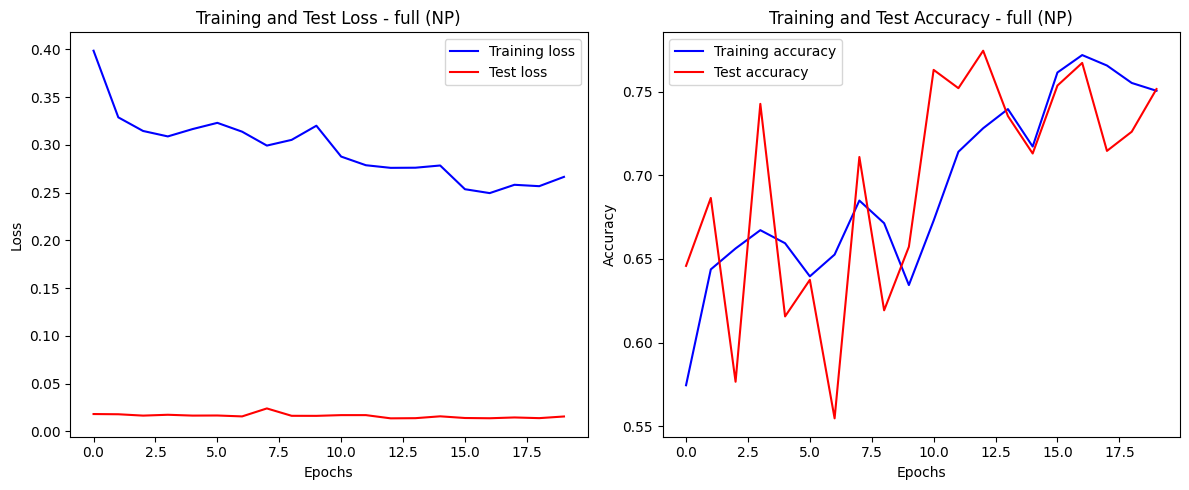

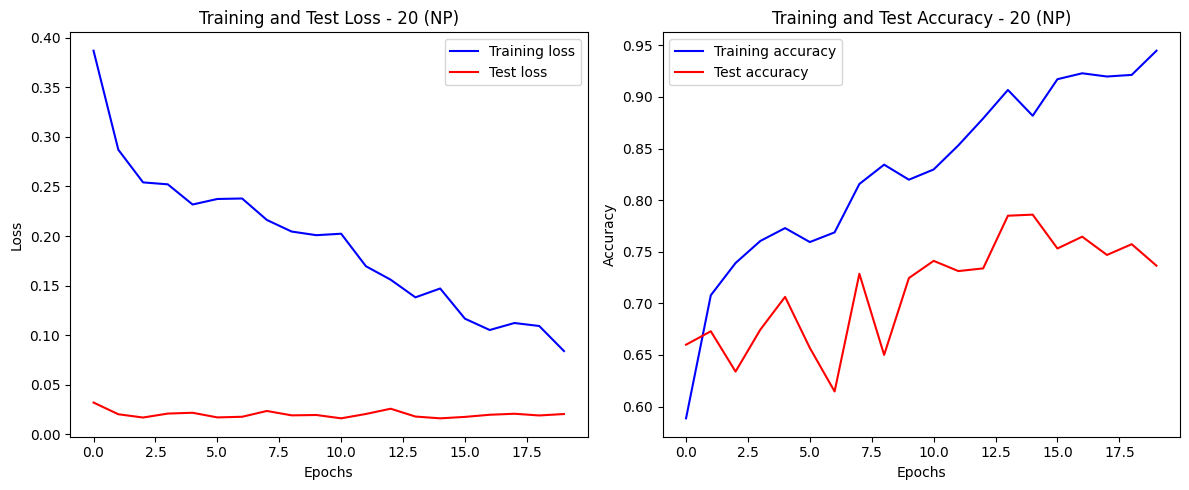

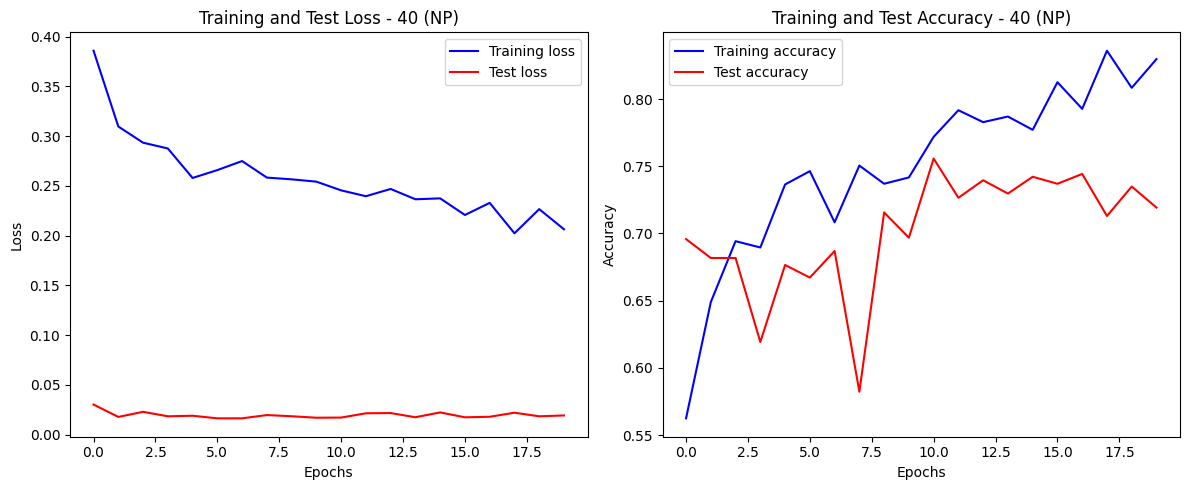

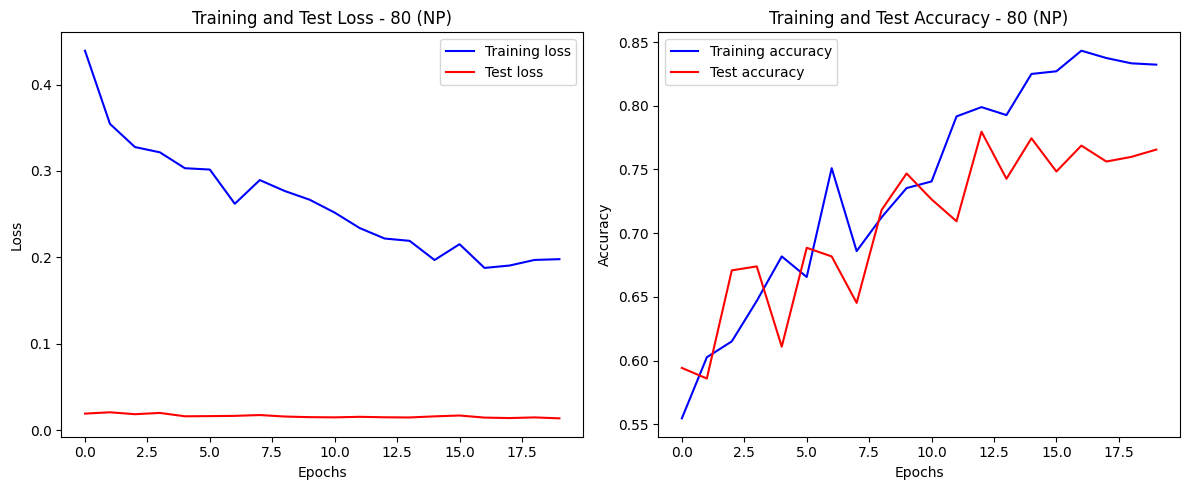

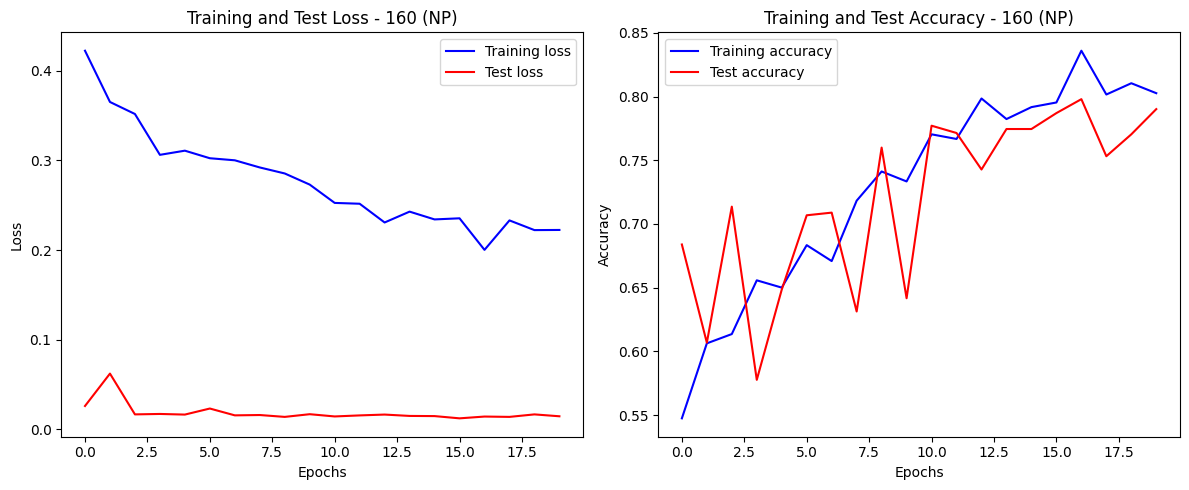

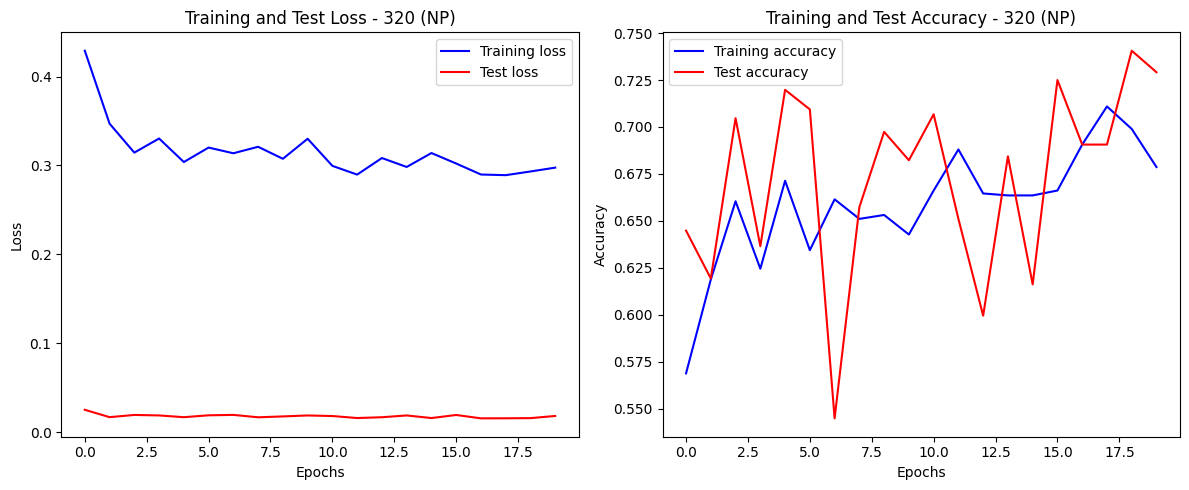

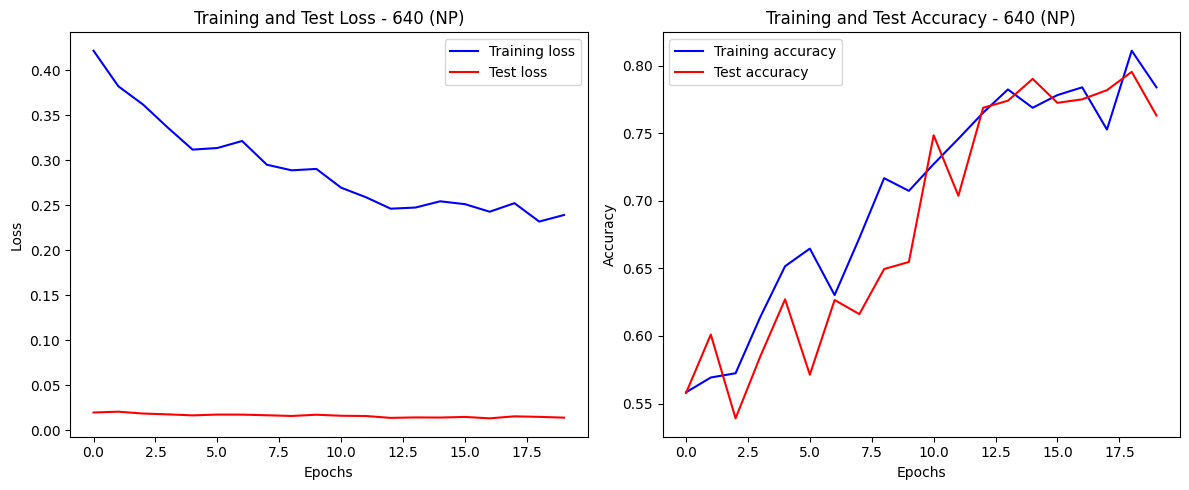

In [48]:
def plot_accuracy_loss(ovrl_history, add_title=""):
    train_loss = [loss/100 for loss in ovrl_history['train']['loss']]
    train_acc = ovrl_history['train']['acc']
    test_loss = ovrl_history['test']['loss']
    test_acc = [acc/100 for acc in ovrl_history['test']['acc']]

    epochs = range(len(train_loss))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b', label='Training loss')
    plt.plot(epochs, test_loss, 'r', label='Test loss')
    plt.title(f'Training and Test Loss - {add_title}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'b', label='Training accuracy')
    plt.plot(epochs, test_acc, 'r', label='Test accuracy')
    plt.title(f'Training and Test Accuracy - {add_title}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


for log in incremental_logs:
    plot_accuracy_loss(log[1], f"{log[0]} (NP)")


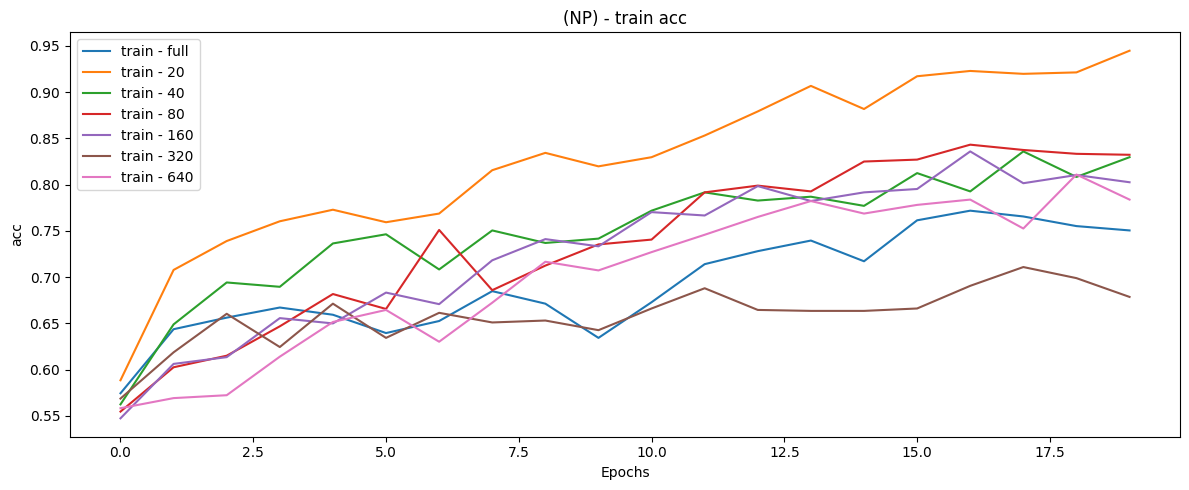

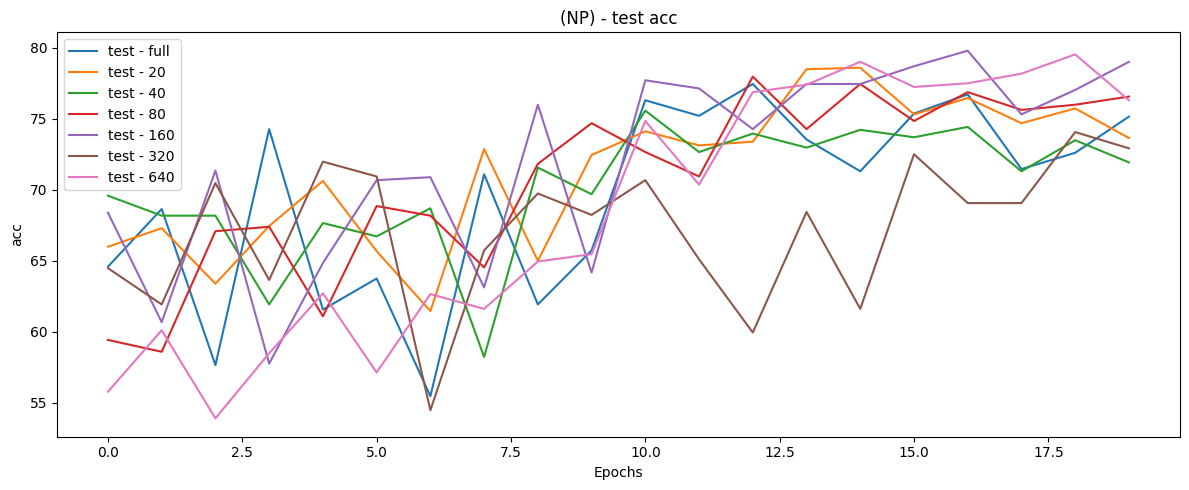

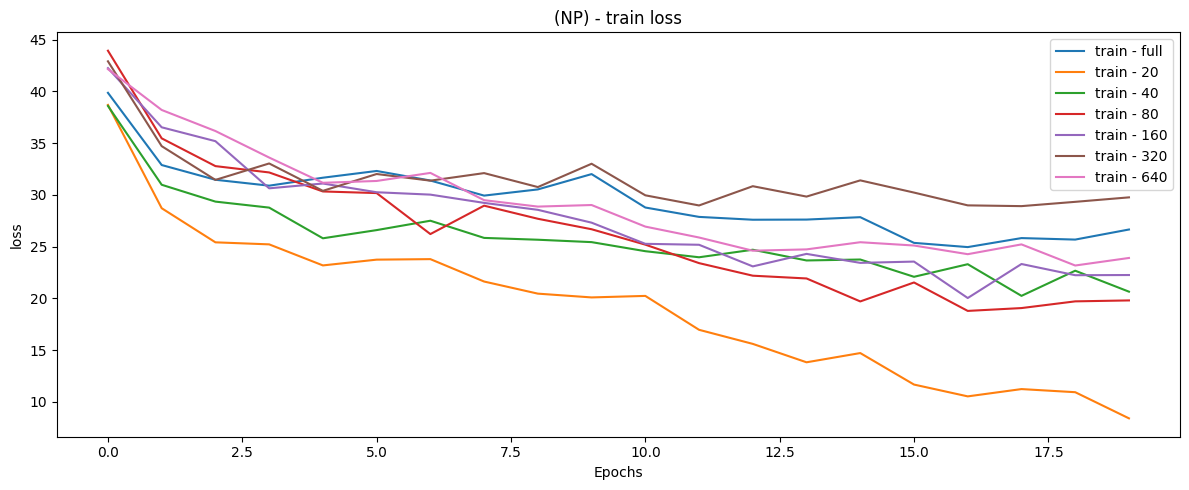

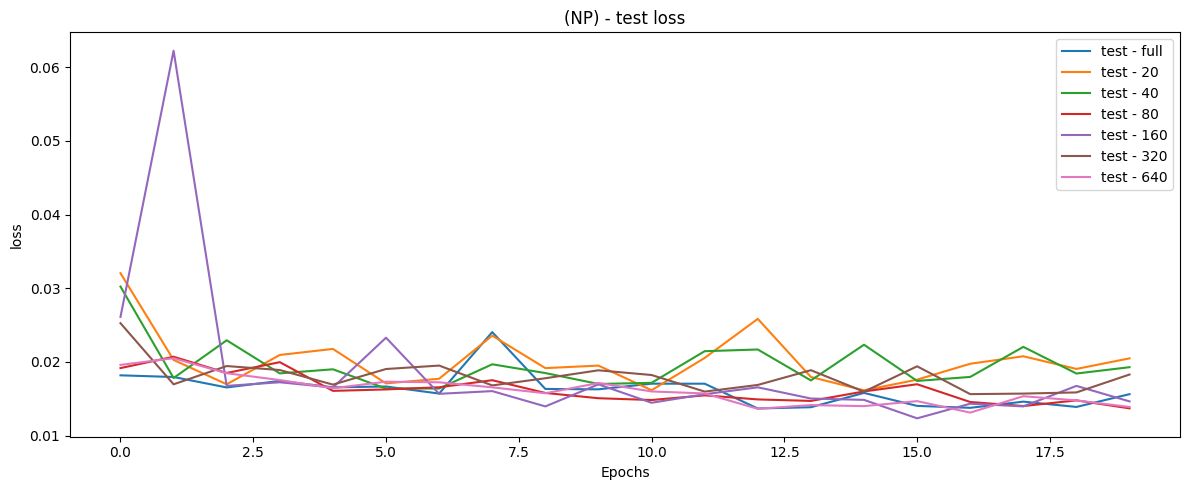

In [49]:
def plot_by_incremental(logs, train_test="train", acc_loss="acc", add_title=""):
    epochs = range(20)
    plt.figure(figsize=(12, 5))
    for log in logs:
        plt.plot(epochs, log[1][train_test][acc_loss], label=f'{train_test} - {log[0]}')
    plt.title(f'{add_title} - {train_test} {acc_loss}')
    plt.xlabel('Epochs')
    plt.ylabel(f'{acc_loss}')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_by_incremental(incremental_logs, "train", add_title="(NP)")    # NP = Not Pretrained
plot_by_incremental(incremental_logs, "test", add_title="(NP)")

plot_by_incremental(incremental_logs, "train", "loss", add_title="(NP)")
plot_by_incremental(incremental_logs, "test", "loss", add_title="(NP)")

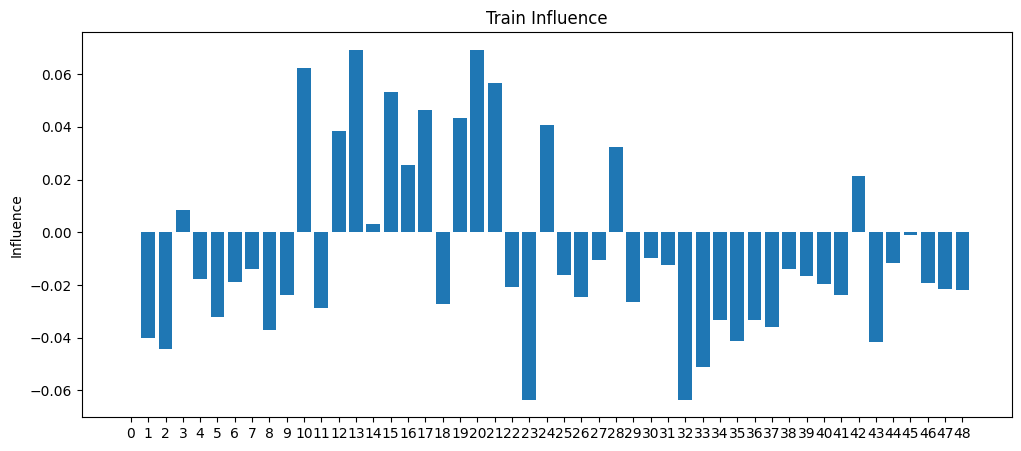

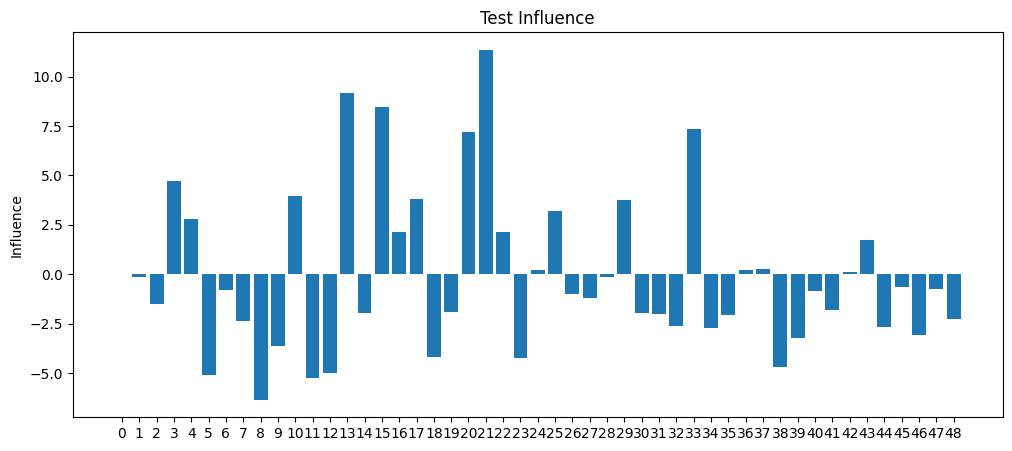

In [ ]:
def bar_plot_influence(influence, title):
    # Extract x labels and y values from the data
    x_labels = [item[0] for item in influence]
    y_values = [item[1] for item in influence]
    plt.figure(figsize=(12, 5))

    # Create a bar plot
    plt.bar(range(len(x_labels)), y_values)

    # Set x-axis labels
    plt.xticks(range(len(x_labels)))

    # Set y-axis label
    plt.ylabel('Influence')

    # Set plot title
    plt.title(title)

    # Display the plot
    plt.show()

def get_influence(drive_path, train_or_test="train"):
    paths_list = paths_list = [path.split('.')[0] for path in listdir(drive_path) if not "incremental" in path]
    all_logs_paths = sorted(paths_list, key=lambda x: int(x.split('_')[3]))
    acc_original = load_logs(all_logs_paths[0])[train_or_test]["acc"][-1]
    influence = []
    for log_path in all_logs_paths:
        log_loaded = load_logs(log_path)
        # get last element of acc of log
        acc = log_loaded[train_or_test]["acc"][-1]
        influence.append([(log_path.split("_")[2],log_path.split("_")[3]), acc_original-acc])
    return influence

bar_plot_influence(get_influence(drive_path), "Train Influence")

bar_plot_influence(get_influence(drive_path, "test"), "Test Influence")

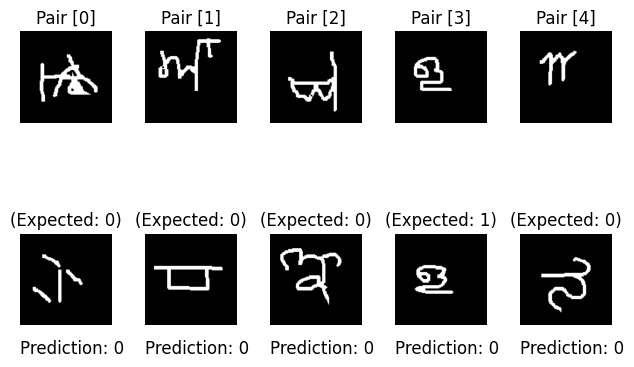

In [ ]:

def plot_images(analyzer, model, test_loader, num_pairs=5):
    model.eval()
    test_loss = 0
    correct = 0

    criterion = nn.BCELoss()

    with torch.no_grad():
        for i, (imgs1, imgs2, targets) in enumerate(test_loader):
            imgs1, imgs2, targets = imgs1.to(device), imgs2.to(device), targets.to(device)
            outputs = model(imgs1, imgs2).squeeze()
            pred = torch.where(outputs > analyzer.threshold, 1, 0)
            # Convert tensors to numpy arrays and reshape
            for j in range(num_pairs):
                img1 = np.transpose(imgs1[j].cpu().numpy(), (1, 2, 0))
                img2 = np.transpose(imgs2[j].cpu().numpy(), (1, 2, 0))
                label = f"Expected: {int(targets[j])}"

                plt.subplot(2, num_pairs, j + 1)
                plt.imshow(img1.astype(np.uint8))
                plt.axis('off')
                plt.title(f'Pair [{j}]')

                plt.subplot(2, num_pairs, num_pairs + j + 1)
                plt.imshow(img2.astype(np.uint8))
                plt.axis('off')
                plt.title(f'({label})')
                plt.text(0, -0.15, f'Prediction: {pred[j]}', transform=plt.gca().transAxes, fontsize=12, ha='left', va='top')
            break
    plt.tight_layout()
    plt.show()

plot_images(analyzer, analyzer.model_pretrained, test_loader)